# Adhesin Classification

In [4]:
%%capture
!pip install Biopython
!rm -r iFeature
!rm -r spaan
!git clone https://github.com/Superzchen/iFeature
!git clone https://github.com/nicolagulmini/spaan

import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO

np.random.seed(42)

## Compute features from sequences using iFeature

In [ ]:
'''
# put the right path
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type AAC --out aac_cleaned_pos.out    # amino acids composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type DPC --out dpc_cleaned_pos.out    # dipeptide composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDC --out ctdc_cleaned_pos.out  # composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDT --out ctdt_cleaned_pos.out  # transition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDD --out ctdd_cleaned_pos.out  # distribution

print("pos: DONE!")

!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type AAC --out aac_cleaned_neg.out    # amino acids composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type DPC --out dpc_cleaned_neg.out    # dipeptide composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type CTDC --out ctdc_cleaned_neg.out  # composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type CTDT --out ctdt_cleaned_neg.out  # transition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type CTDD --out ctdd_cleaned_neg.out  # distribution

print("neg: DONE!")
'''

In [5]:
def from_files_to_vectors(fasta_path, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'adhesins.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'non_adhesins.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_pos"
    else:
        names = "_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    return datasets
                datasets[i].append(np.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = np.array(datasets[i])
    return datasets

In [6]:
# put the right path
pos_datasets = from_files_to_vectors("./spaan/data/25_similarity/positive/", positive=True)
neg_datasets = from_files_to_vectors("./spaan/data/25_similarity/negative/", positive=False)

In [7]:
y_pos = np.ones(pos_datasets[0].shape[0])
y_neg = np.zeros(neg_datasets[0].shape[0])

In [8]:
# attach datasets in order to obtain a matrix of (n, 20+400+39+39+195) features

# keep in mind the number of adhesins and the number of not adhesins
rows = 0
n_pos = y_pos.shape[0]
n_neg = y_neg.shape[0]
rows = n_pos + n_neg
print('Adhesins:', n_pos)
print('NON Adhesins:', n_neg)

# feature vectors dimensions
columns = 0
for i in range(len(pos_datasets)):
    tmp_dim = pos_datasets[i].shape[1]
    print(i+1, '-th feature dim:', tmp_dim)
    columns += tmp_dim

# data matrix to process
X = np.zeros((rows, columns))
print('Data matrix dimension:', X.shape)
for i in range(n_pos):
    X[i] = np.concatenate([pos_datasets[j][i] for j in range(5)])
for i in range(n_neg):
    X[n_pos+i] = np.concatenate([neg_datasets[j][i] for j in range(5)])

Adhesins: 3714
NON Adhesins: 3710
1 -th feature dim: 20
2 -th feature dim: 400
3 -th feature dim: 39
4 -th feature dim: 39
5 -th feature dim: 195
Data matrix dimension: (7424, 693)


In [9]:
# permutation
y = np.concatenate((y_pos, y_neg), axis=0)
c = np.random.permutation(np.arange(y.shape[0]))
y = y[c]
X = X[c] 

In [ ]:
# we should remove outliers

In [10]:
# remember: standardization or scaling AFTER train-test split, otherwise there's data leakage!!!
X_train = X[:int(X.shape[0]*.5)]
X_val = X[int(X.shape[0]*.5):int(X.shape[0]*.75)]
X_test = X[int(X.shape[0]*.75):]

y_train = y[:int(y.shape[0]*.5)]
y_val = y[int(y.shape[0]*.5):int(y.shape[0]*.75)]
y_test = y[int(y.shape[0]*.75):]

print('Training data shape:', X_train.shape, y_train.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test data shape:', X_test.shape, y_test.shape)

print('\nTraining adhesins and not-adhesins:', int(sum(y_train)), int(y_train.shape[0]-sum(y_train)))
print('Validation adhesins and not-adhesins:', int(sum(y_val)), int(y_val.shape[0]-sum(y_val)))
print('Test adhesins and not-adhesins:', int(sum(y_test)), int(y_test.shape[0]-sum(y_test)))

Training data shape: (3712, 693) (3712,)
Validation data shape: (1856, 693) (1856,)
Test data shape: (1856, 693) (1856,)

Training adhesins and not-adhesins: 1871 1841
Validation adhesins and not-adhesins: 915 941
Test adhesins and not-adhesins: 928 928


## PCA

In [11]:
# standardize data

# print some column vectors to check
print('Before standardization:')
print('mean of the first column:', np.mean(X_train[:,0]))
print('mean of the second column:', np.mean(X_train[:,1]))
print('mean of the 451-th column:', np.mean(X_train[:,450]))

stdX = np.zeros(X_train.shape)
for j in range(X_train.shape[1]):
    column = X_train[:,j]
    stdX[:,j] = (column - np.mean(column)) / np.std(column)

print('After standardization:')
print('mean of the first column:', np.mean(stdX[:,0]))
print('mean of the second column:', np.mean(stdX[:,1]))
print('mean of the 451-th column:', np.mean(stdX[:,450]))

Before standardization:
mean of the first column: 0.08880933224780413
mean of the second column: 0.009663377891283477
mean of the 451-th column: 0.09716150108079744
After standardization:
mean of the first column: -1.761043418370938e-16
mean of the second column: -2.0194573982405864e-16
mean of the 451-th column: 2.679848680129688e-16


In [12]:
covariance_matrix = np.cov(stdX.T)

In [13]:
# The covariance matrix is symmetric, and thus has real eigenvalues. You may see a small imaginary part in some eigenvalues due to numerical error. The imaginary parts can generally be ignored.
# source: https://stackoverflow.com/questions/10420648/complex-eigen-values-in-pca-calculation

eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
eigen_values = np.real(eigen_values)
eigen_vectors = np.real(eigen_vectors)

In [14]:
# Calculating the explained variance on each of components

variance_explained = []
for i in eigen_values:
    variance_explained.append((i/sum(eigen_values))*100)

print(variance_explained)

[7.869069602568453, 5.5595276283950215, 4.042866351508088, 3.6187567898821986, 3.0290279070168813, 2.8819678095578816, 1.7063355247317253, 1.5197887907830279, 1.439347488622184, 1.2883615690424721, 1.057200513048839, 0.9577101209115998, 0.9390892962513744, 0.8978987346030655, 0.8559236233916053, 0.7958776770900606, 0.7834411501347968, 0.7345336341244294, 0.6848958754888097, 0.645087083090097, 0.6343174254800849, 0.6193124417316408, 0.5990014134319815, 0.5745621229802202, 0.5565285175459893, 0.5289628854101027, 0.5159926516177133, 0.5120977432773964, 0.49779043141004087, 0.48081955602739246, 0.4756467431476344, 0.44935827311318394, 0.4288979613279147, 0.4213209036086662, 0.413398855794988, 0.3942326037125037, 0.3887519996422747, 0.3733932879045171, 0.3631624337688395, 0.3505032956740338, 0.3390760942943872, 0.3327055108694564, 0.32963162668462165, 0.3254496713139554, 0.31651041829657545, 0.3076053159298473, 0.30486322740953764, 0.2979720596137911, 0.2969485416652127, 0.2922864390993799,

In [15]:
cumulative_variance_explained = np.cumsum(variance_explained)

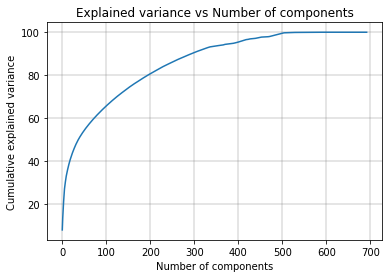

In [16]:
plt.title("Explained variance vs Number of components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(len(cumulative_variance_explained)), cumulative_variance_explained)

plt.show()
#plt.savefig('Explained variance.png')

In [17]:
K = 400
print('Principal components:', K)
print('Discarded components:', columns-K)

Principal components: 400
Discarded components: 293


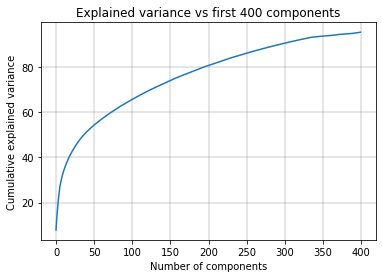

In [18]:
plt.title("Explained variance vs first " + str(K) + " components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(K), cumulative_variance_explained[:K])

plt.show()
#plt.savefig('Explained variance.png')

In [19]:
# Project using first K components

projection_matrix = np.real((eigen_vectors.T[:][:K]).T)
print(projection_matrix.shape)

(693, 400)


In [20]:
# standardize validation and test data and then project

stdX_val = np.zeros(X_val.shape)
for j in range(X_val.shape[1]):
    column = X_val[:,j]
    stdX_val[:,j] = (column - np.mean(column)) / np.std(column)

stdX_test = np.zeros(X_test.shape)
for j in range(X_test.shape[1]):
    column = X_test[:,j]
    stdX_test[:,j] = (column - np.mean(column)) / np.std(column)

# project matrices
X_train = stdX.dot(projection_matrix)
X_val = stdX_val.dot(projection_matrix)
X_test = stdX_test.dot(projection_matrix)

## Neural Network

In [77]:
from tensorflow.keras import regularizers

class neural_network:
    def __init__(self):
        input = tensorflow.keras.Input(shape=(K,))
        
        dense = tensorflow.keras.layers.Dense(units=10, 
                                                activation='sigmoid',
                                                kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                                                bias_regularizer=regularizers.L2(1e-3),
                                                activity_regularizer=regularizers.L2(1e-3))(input)
        #norm = tensorflow.keras.layers.BatchNormalization()(dense)
        #drop = tensorflow.keras.layers.Dropout(.1)(dense)
        #dense = tensorflow.keras.layers.Dense(10, activation='sigmoid')(drop)
        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tensorflow.keras.models.Model(inputs=input, outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics='accuracy')
        self.model = model

In [90]:
nn = neural_network()

In [91]:
nn.model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 400)]             0         
                                                                 
 dense_25 (Dense)            (None, 10)                4010      
                                                                 
 dense_26 (Dense)            (None, 1)                 11        
                                                                 
Total params: 4,021
Trainable params: 4,021
Non-trainable params: 0
_________________________________________________________________


In [92]:
history = nn.model.fit(
    x=X_train, 
    y=y_train,
    batch_size=64,
    epochs=1000,
    verbose=1,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=5
        )]
)

Epoch 1/1000
58/58 [==============================] - 1s 6ms/step - loss: 0.9513 - accuracy: 0.5151 - val_loss: 0.8889 - val_accuracy: 0.5226
Epoch 2/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.8192 - accuracy: 0.5744 - val_loss: 0.7739 - val_accuracy: 0.6304
Epoch 3/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.7101 - val_loss: 0.6826 - val_accuracy: 0.7419
Epoch 4/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.8077 - val_loss: 0.6089 - val_accuracy: 0.8103
Epoch 5/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.5595 - accuracy: 0.8640 - val_loss: 0.5505 - val_accuracy: 0.8470
Epoch 6/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.5035 - accuracy: 0.8855 - val_loss: 0.5022 - val_accuracy: 0.8648
Epoch 7/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.4571 - accuracy: 0.9027 - val_loss: 0.4623 - val_accuracy: 0.8728
Epoch 

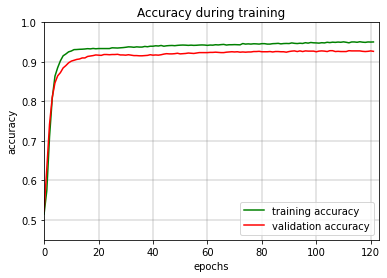

In [93]:
plt.title('Accuracy during training')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label='training accuracy', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label='validation accuracy', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0, len(history.history['loss'])+1)
plt.ylim(.45, 1.)
plt.savefig('acc.png')

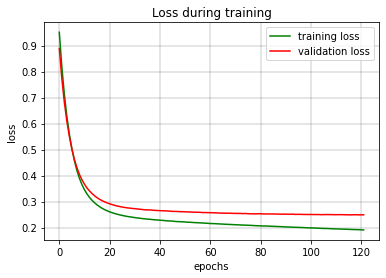

In [94]:
plt.title('Loss during training')
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='training loss', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='validation loss', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('loss.png')

In [95]:
nn.model.evaluate(x=X_test, y=y_test)

58/58 [==============================] - 0s 2ms/step - loss: 0.2142 - accuracy: 0.9397


[0.214177668094635, 0.9396551847457886]

In [96]:
nn.model.save('ac.h5')

In [ ]:
# I thought that we can obtain these results also without using a neural network